#                                                  Phone Price Predictor
### By Akash Saini

<img src="smartphones_image.jpg" alt="Flights" width="500">


# Step 1: Problem statement

**Smartphone pricing is a critical challenge for businesses and consumers alike. With thousands of models launched every year, retailers often struggle to set competitive, data-driven prices, while consumers find it difficult to evaluate whether a device is worth its cost. This mismatch leads to inefficient pricing strategies, revenue loss for businesses, and poor decision-making for buyers.**

**To solve this business problem, I built the Smartphone Price Predictor, a machine learning solution that leverages smartphone specifications (RAM, storage, battery, processor, camera, etc.) to predict prices with accuracy. The model provides:**

**Actionable insights for businesses to optimize pricing strategies and remain competitive in the market.**

 **Confidence for consumers in identifying fair prices and making smarter purchase decisions.**

**By aligning product specifications with real market value, this project demonstrates how data science can directly impact pricing strategy, customer trust, and overall business performance**

In [4]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
df = pd.read_csv("smartphone.csv")

In [5]:
df.head()

,Brand,Memory,Camera,Battery,Processor,Ratings,Reviews,Price
0,"Infinix Note 30 5G (Sunset Gold, 256 GB)",8 GB RAM | 256 GB ROM | Expandable Upto 2 TB,108 MP + 2 MP+ AI Lens | 16MP Front Camera,5000 mAh Li-ion Polymer Battery,Dimensity 6080 Processor,4.2,"81,666 Ratings & 8,897 Reviews","₹14,999"
1,"REDMI 12 5G (Moonstone Silver, 128 GB)",6 GB RAM | 128 GB ROM | Expandable Upto 1 TB,50MP + 2MP | 8MP Front Camera,5000 mAh Battery,Snapdragon 4 Gen 2 Processor,4.3,"17,785 Ratings & 1,158 Reviews","₹12,999"
2,"Apple iPhone 15 (Black, 128 GB)",128 GB ROM,48MP + 12MP | 12MP Front Camera,"A16 Bionic Chip, 6 Core Processor Processor",1 Year Warranty for Phone and 6 Months Warrant...,4.6,"13,517 Ratings & 921 Reviews","₹65,999"
3,"Motorola G34 5G (Ice Blue, 128 GB)",8 GB RAM | 128 GB ROM,50MP + 2MP | 16MP Front Camera,5000 mAh Battery,Snapdragon 695 5G Processor,4.2,"6,022 Ratings & 836 Reviews","₹11,999"
4,"vivo T2 5G (Nitro Blaze, 128 GB)",8 GB RAM | 128 GB ROM,64 MP (OIS) + 2MP | 16MP Front Camera,4500 mAh Battery,Snapdragon 695 Processor,4.3,"16,572 Ratings & 1,166 Reviews","₹17,999"


- Above is the dataset containing information about the smartphones
- Columns are Brand, Memory, Camera, Battery, Processor, Ratings, Reviews and Price
- Brand includes the names of brand of the smartphones in different rows
- Memory contains information about the ROM and ROM
- Camera cantains the number and the megapixels of both the front and the Rear Cameras
- Battery contains the size of the Battery in mAh
- Rating contains the Ratings given by the customers to different smartphones
- Reviews contains the number of customers which has rated the smartphone and written the Reviews about the smartphone
- Price includes the amount you have give in order to purchase the smartphone

# Step 2: Data Preprocessing

In [8]:
#basic info of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Brand      984 non-null    object 
 1   Memory     984 non-null    object 
 2   Camera     984 non-null    object 
 3   Battery    984 non-null    object 
 4   Processor  984 non-null    object 
 5   Ratings    979 non-null    float64
 6   Reviews    979 non-null    object 
 7   Price      983 non-null    object 
dtypes: float64(1), object(7)
memory usage: 61.6+ KB


In [9]:
# checking for null values
df.isnull().sum()

Brand        0
Memory       0
Camera       0
Battery      0
Processor    0
Ratings      5
Reviews      5
Price        1
dtype: int64

In [10]:
# dropping the null values
df.dropna(inplace =True)

In [11]:
# checking the duplicates values
df.duplicated().sum()

313

In [12]:
# dropping the duplicate values
df.drop_duplicates(inplace=True)

In [13]:
df.duplicated().sum()

0

In [14]:
# taking out the brand name to a separate column
df["Brand_name"] = df["Brand"].str.split().str[0]

In [15]:
df.sample(3)

,Brand,Memory,Camera,Battery,Processor,Ratings,Reviews,Price,Brand_name
260,"REDMI 13c 5G (Starlight Black, 256 GB)",8 GB RAM | 256 GB ROM,50MP Rear Camera,5000 mAh Battery,1 Year,4.2,793 Ratings & 59 Reviews,"₹14,202",REDMI
330,"realme Narzo N55 (Prime Black, 128 GB)",6 GB RAM | 128 GB ROM,64MP Rear Camera,5000 mAh Battery,1 Year Domestic Warranty for Phone and 6 Month...,4.3,"4,294 Ratings & 235 Reviews","₹9,929",realme
75,"OnePlus Nord CE 3 Lite 5G (Chromatic Gray, 128...",8 GB RAM | 128 GB ROM,108MP Rear Camera,5000 mAh Battery,Domestic Warranty of 12 months on phone & 6 mo...,4.4,"52,460 Ratings & 3,674 Reviews","₹18,999",OnePlus


In [16]:
# making a separate column for the availability of the 5g phones
df["5G"] = df["Brand"].apply(lambda x : 1 if "5G" in x else 0)

In [17]:
# making a function which will store the RAM values in separate column
# as the ram of all the apple smartphones are not given
# so this function will assign ram = 4GB where ever it will find the apple smartphones
# 4GB is the average value of the ram size of apple smartphones

def ram_splitter(brand, memory):
    brand = str(brand)
    memory = str(memory)

    if "RAM" in memory:
        return memory.split("|")[0]
    elif "Apple" in brand:
        return "4GB"
    else:
        return 0

df["RAM"] = df[["Brand_name", "Memory"]].apply(lambda x: ram_splitter(x["Brand_name"], x["Memory"]), axis=1)

In [18]:
# making a function which will store the ROM values in separate column
def extract_rom(memory):

    memory_parts = memory.split("|")

    rom = None

    for part in memory_parts:
        part = part.strip()

        if "GB ROM" in part or "TB ROM" in part:
            rom = part.replace("ROM", "").strip()

    return rom

df["ROM"] = df["Memory"].apply(extract_rom)

In [19]:
df.sample(3)

,Brand,Memory,Camera,Battery,Processor,Ratings,Reviews,Price,Brand_name,5G,RAM,ROM
282,"SAMSUNG Galaxy M04 (Dark Blue, 64 GB)",4 GB RAM | 64 GB ROM | Expandable Upto 1 TB,13MP + 13MP | 5MP + 5MP Dual Front Camera,5000 mAh Battery,MediaTek Helio P35 octa core Processor,4.1,"9,830 Ratings & 563 Reviews","₹6,708",SAMSUNG,0,4 GB RAM,64 GB
273,"IQOO Z7s 5G (Norway Blue, 128 GB)",6 GB RAM | 128 GB ROM,64MP Rear Camera,4500 mAh Battery,Domestic 1 Year on Handset and 6 Months on Acc...,4.3,"2,443 Ratings & 147 Reviews","₹15,650",IQOO,1,6 GB RAM,128 GB
553,"Nokia 5310 DS Keypad Mobile, FM Radio,Camera w...",8 MB RAM | 16 MB ROM | Expandable Upto 32 GB,0.3MP Rear Camera,1200 mAh Lithium-ion Battery,MT6260A Processor,4.1,"9,077 Ratings & 645 Reviews","₹3,409",Nokia,0,8 MB RAM,None


In [20]:
# separate columns for the back_camera and the front camera
df["Main_camera"] = df["Camera"].apply(lambda x: x.split("|")[0] if "|" in x else x)
df["Front_camera"] = df["Camera"].apply(lambda x: x.split("|")[1] if "|" in x else 0)

In [21]:
# separate columns for the processor_name, rating and reviews
df["Processor_name"] = df["Processor"].str.split().str[0]
df["Ratings_count"] = df["Reviews"].str.split("&").str[0]
df["Reviews_count"] = df["Reviews"].str.split("&").str[1]

In [22]:
df.sample(3)

,Brand,Memory,Camera,Battery,Processor,Ratings,Reviews,Price,Brand_name,5G,RAM,ROM,Main_camera,Front_camera,Processor_name,Ratings_count,Reviews_count
208,"Motorola Edge 40 Neo (Peach Fuzz, 256 GB)",12 GB RAM | 256 GB ROM,50MP + 13MP | 32MP Front Camera,5000 mAh Battery,Dimensity 7030 Processor,4.3,"36,416 Ratings & 4,886 Reviews","₹24,999",Motorola,0,12 GB RAM,256 GB,50MP + 13MP,32MP Front Camera,Dimensity,"36,416 Ratings","4,886 Reviews"
850,"OnePlus N20 SE (BLUE OASIS, 64 GB)",4 GB RAM | 64 GB ROM,50MP Rear Camera,5000 mAh Battery,No Warranty.,4.2,234 Ratings & 11 Reviews,"₹13,769",OnePlus,0,4 GB RAM,64 GB,50MP Rear Camera,0,No,234 Ratings,11 Reviews
274,POCO C51 - Locked with Airtel Prepaid (Power B...,4 GB RAM | 64 GB ROM | Expandable Upto 1 TB,8MP Dual Rear Camera | 5MP Front Camera,5000 mAh Battery,Helio G36 Processor,4.0,"1,78,997 Ratings & 9,966 Reviews","₹4,999",POCO,0,4 GB RAM,64 GB,8MP Dual Rear Camera,5MP Front Camera,Helio,"1,78,997 Ratings","9,966 Reviews"


In [23]:
# dropping the columns which are no longer needed
df.drop(columns = ["Brand", "Memory", "Camera", "Processor"], inplace = True)

In [24]:
# making average size of the iphone battery = 3000
df["Battery_mAh"] = df["Battery"].apply(lambda x: x.split("mAh")[0] if "mAh" in x else 3000)

In [25]:
# dropping the columns which are no longer needed
df.drop(columns=["Battery", "Reviews"], inplace = True)

In [26]:
# making the columns data to integers
def make_integer(row):
    row = str(row)
    integers= []
    for i in row:
        if i.isdigit():
            integers.append(i)
    return "".join(integers)

In [27]:
df["Price"] = df["Price"].apply(make_integer)
df["Ratings_count"] = df["Ratings_count"].apply(make_integer)
df["Reviews_count"] = df["Reviews_count"].apply(make_integer)
df["Front_camera"] = df["Front_camera"].apply(make_integer)

In [28]:
# making a function which will assign "bionic" to apple processor
def apple_processor(name, processor):
    name = str(name)
    processor = str(processor)

    if name == "Apple":
        return "Bionic"
    else:
        return processor

df["Processor_name"] = df[["Brand_name", "Processor_name"]].apply(lambda x : apple_processor(x["Brand_name"], x["Processor_name"]), axis=1)

In [29]:
# categorize the processor into few categories
def processor_name(row):
    row = str(row)

    if row == "Bionic":
        return row
    elif row == "Qualcomm" or row == "Snapdragon":
        return "Snapdragon"
    elif row == "Mediatek" or row == "MediaTek" or row == "Helio" or row == "Dimensity":
        return "Mediatek"
    else:
        return "Others"

df["Processor_name"] = df["Processor_name"].apply(processor_name)

In [30]:
df["Processor_name"].value_counts()

Processor_name
Others        279
Mediatek      221
Snapdragon    110
Bionic         55
Name: count, dtype: int64

In [31]:
# adding all the megapixel of the back cameras
def total_megapixels(camera):
    camera = str(camera)
    if "MP" in camera:
        cameras = camera.split("+")

        total_mp = 0


        for cam in cameras:

            mp_str = ''.join(filter(str.isdigit, cam))
            mp = int(mp_str) if mp_str else 0
            total_mp += mp

        return total_mp
    else:
        return 0
df["Back_camera_sum"] = df["Main_camera"].apply(total_megapixels)

In [32]:
def rom(row):
    row = str(row)

    if "TB" in row:
        return "1000"
    else:
        return row.split()[0]

df["ROM"] = df["ROM"].apply(rom)

In [33]:
df = df.drop(df[df["ROM"] == "nan"].index)

In [34]:
df["RAM"].value_counts()

RAM
8 GB RAM      231
4 GB RAM      147
6 GB RAM      116
12 GB RAM      64
4GB            55
3 GB RAM       23
2 GB RAM       17
16 GB RAM       7
8 MB RAM        1
3 MB RAM        1
32 MB RAM       1
4 MB RAM        1
64 GB RAM       1
Name: count, dtype: int64

In [35]:
# removing the GB term from the RAM
def ram(row):
    row = str(row)

    if "GB" in row:
        return row.split("GB")[0]
    else:
        return 0
df["RAM"] = df["RAM"].apply(ram)

In [36]:
# removing the outliers
df = df.drop(df[df["RAM"] == "64 "].index)

In [37]:
df.drop(columns = ["Main_camera"], inplace = True)

In [38]:
df = df.drop(df[df["ROM"] == "None"].index)
df["ROM"].value_counts()

ROM
128     347
256     148
64      115
512      22
32       22
1000      5
16        2
Name: count, dtype: int64

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 661 entries, 0 to 983
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Ratings          661 non-null    float64
 1   Price            661 non-null    object 
 2   Brand_name       661 non-null    object 
 3   5G               661 non-null    int64  
 4   RAM              661 non-null    object 
 5   ROM              661 non-null    object 
 6   Front_camera     661 non-null    object 
 7   Processor_name   661 non-null    object 
 8   Ratings_count    661 non-null    object 
 9   Reviews_count    661 non-null    object 
 10  Battery_mAh      661 non-null    object 
 11  Back_camera_sum  661 non-null    int64  
dtypes: float64(1), int64(2), object(9)
memory usage: 67.1+ KB


In [40]:
df.sample(5)

,Ratings,Price,Brand_name,5G,RAM,ROM,Front_camera,Processor_name,Ratings_count,Reviews_count,Battery_mAh,Back_camera_sum
623,4.3,17999,OPPO,1,8,128,8,Others,6696,435,5000,52
55,4.5,23999,vivo,1,8,128,16,Mediatek,68698,6048,4600,66
708,4.3,8999,Infinix,0,4,64,8,Others,120882,8533,6000,13
484,4.4,36990,OnePlus,1,16,256,0,Others,1297,113,5000,50
610,3.9,64999,SAMSUNG,1,8,256,10,Snapdragon,262,19,3700,24


In [41]:
def brand_collection(row):
    row = str(row)

    if "REDMI" in row or "vivo" in row or "realme" in row or "POCO" in row or "Motorola" in row or "Infinix" in row or "OPPO" in row or "Apple" in row or "Google" in row or "OnePlus" in row:
        return row
    elif "SAMSUNG" in row or "Samsung" in row:
        return "Samsung"
    else:
        return "Others"

df["Brand_name"] = df["Brand_name"].apply(brand_collection)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 661 entries, 0 to 983
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Ratings          661 non-null    float64
 1   Price            661 non-null    object 
 2   Brand_name       661 non-null    object 
 3   5G               661 non-null    int64  
 4   RAM              661 non-null    object 
 5   ROM              661 non-null    object 
 6   Front_camera     661 non-null    object 
 7   Processor_name   661 non-null    object 
 8   Ratings_count    661 non-null    object 
 9   Reviews_count    661 non-null    object 
 10  Battery_mAh      661 non-null    object 
 11  Back_camera_sum  661 non-null    int64  
dtypes: float64(1), int64(2), object(9)
memory usage: 67.1+ KB


In [43]:
# make price as integer
df['Price'] = df['Price'].astype("int")
df["Ratings"] = df["Ratings"].astype("object")
df['5G'] = df["5G"].astype("object")
df["Ratings_count"] = df["Ratings_count"].astype("int")
df["Reviews_count"] = df["Reviews_count"].astype('int')


In [44]:
df.columns

Index(['Ratings', 'Price', 'Brand_name', '5G', 'RAM', 'ROM', 'Front_camera',
       'Processor_name', 'Ratings_count', 'Reviews_count', 'Battery_mAh',
       'Back_camera_sum'],
      dtype='object')

In [45]:
col = ['Ratings', 'Brand_name', '5G', 'RAM', 'ROM', 'Front_camera',
       'Processor_name', 'Battery_mAh', 'Back_camera_sum']

for i in col:
    print("Column name:", i)
    print("Unique counts:", df[i].nunique())
    print("Unique values:", list(df[i].unique()))
    print("\n")

Column name: Ratings
Unique counts: 16
Unique values: [4.2, 4.3, 4.6, 4.4, 4.0, 4.5, 4.1, 4.7, 3.7, 4.9, 5.0, 3.8, 3.9, 3.5, 3.1, 3.2]


Column name: Brand_name
Unique counts: 12
Unique values: ['Infinix', 'REDMI', 'Apple', 'Motorola', 'vivo', 'POCO', 'Samsung', 'OnePlus', 'realme', 'Others', 'OPPO', 'Google']


Column name: 5G
Unique counts: 2
Unique values: [1, 0]


Column name: RAM
Unique counts: 9
Unique values: ['8 ', '6 ', '4', '4 ', '12 ', '2 ', '3 ', '16 ', 0]


Column name: ROM
Unique counts: 7
Unique values: ['256', '128', '64', '512', '32', '1000', '16']


Column name: Front_camera
Unique counts: 17
Unique values: ['16', '8', '12', '50', '5', '0', '32', '13', '10', '55', '207', '108', '105', '20', '2', '88', '1616']


Column name: Processor_name
Unique counts: 4
Unique values: ['Mediatek', 'Snapdragon', 'Bionic', 'Others']


Column name: Battery_mAh
Unique counts: 26
Unique values: ['5000 ', 3000, '4500 ', '6000 ', '4600 ', '5100 ', '4700 ', '4400 ', '3700 ', '4000 ', '4270 

### Steps performed in Data Cleaning:
- Removed the null values
- Removed the Duplicate rows
- Created separate columns for RAM and ROM
- Created separate columns for Rear Camera and Back Camera
- Created separate columns for Reviews and Ratings
- Converted the data types to integers of the relevant columns
- Categorize all the processor into 4 groups (Mediatek, Snapdragon, Bionic and others)
- Added all the megapixels of the back camera
- Removed all the non-relevant columns

# Step 3:  Performing Exploratory Data Analysis (EDA)

In [48]:
df.describe()

,Price,Ratings_count,Reviews_count,Back_camera_sum
count,661.000000,6.610000e+02,661.000000,661.000000
mean,26993.972769,3.494355e+04,2474.366112,69.054463
std,29309.320067,7.858881e+04,6228.512029,198.075460
min,4999.000000,1.000000e+01,1.000000,8.000000
25%,10074.000000,7.990000e+02,60.000000,50.000000
50%,15798.000000,4.475000e+03,367.000000,52.000000
75%,29999.000000,2.850300e+04,2423.000000,66.000000
max,179900.000000,1.171746e+06,121980.000000,5028.000000


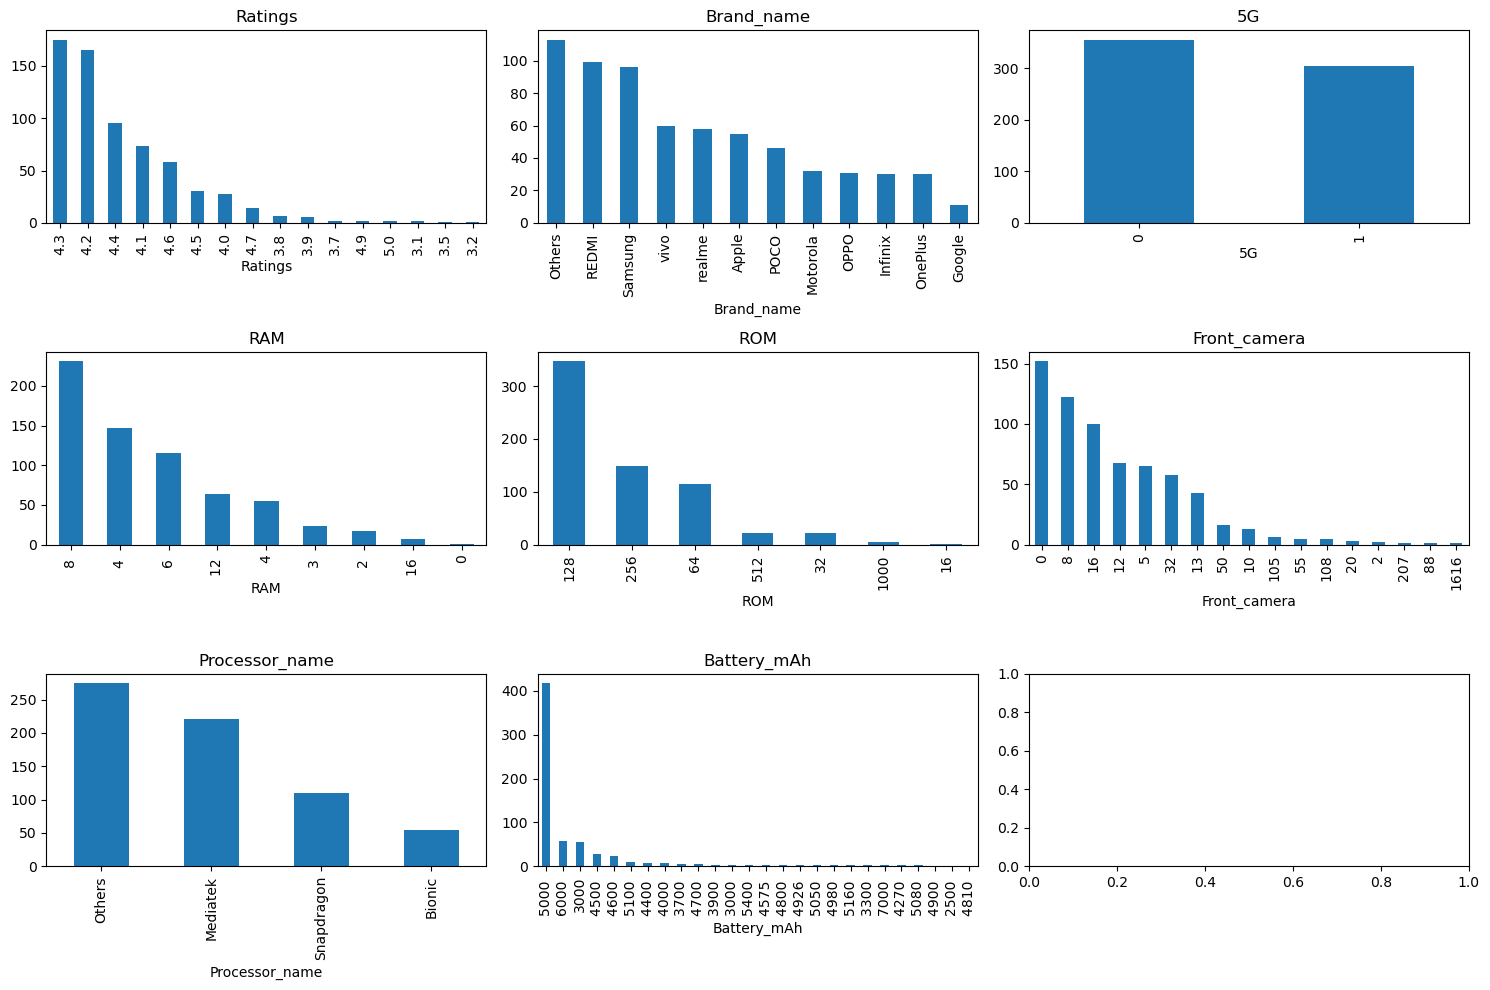

In [49]:
# checking the distribution of each column
col = ['Ratings', 'Brand_name', '5G', 'RAM', 'ROM', 'Front_camera',
       'Processor_name', 'Battery_mAh']

import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()


for i, col_name in enumerate(col):

    df[col_name].value_counts().plot(kind="bar", ax=axes[i])

    axes[i].set_title(col_name)

plt.tight_layout()
plt.show()

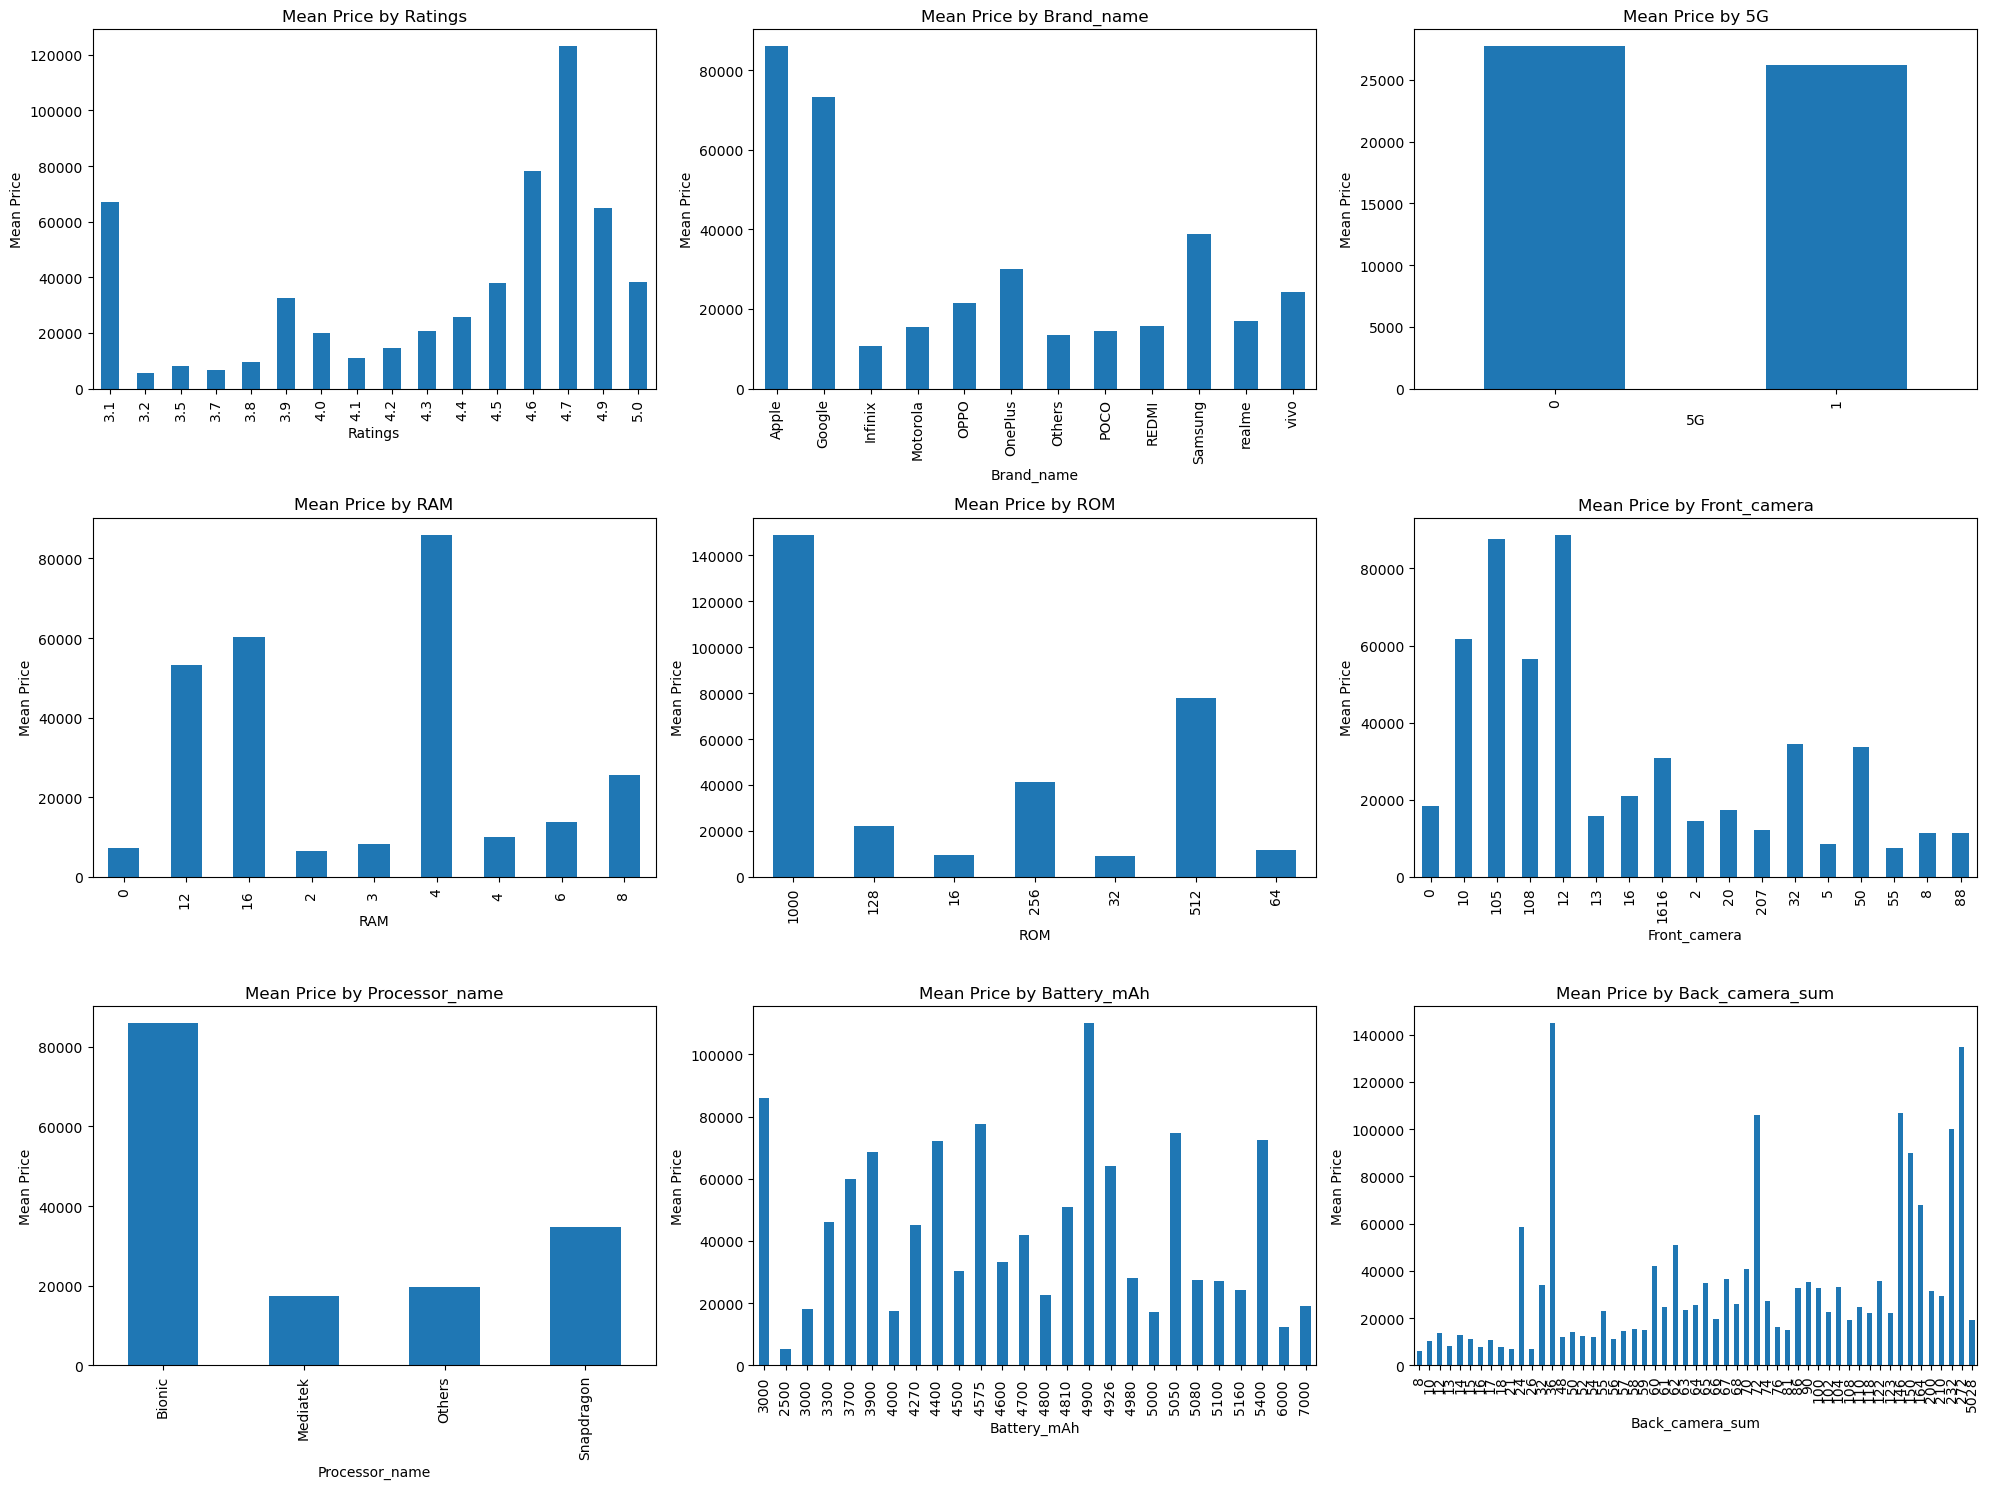

In [50]:
import matplotlib.pyplot as plt

col = ['Ratings', 'Brand_name', '5G', 'RAM', 'ROM', 'Front_camera', 'Processor_name', 'Battery_mAh', 'Back_camera_sum']

fig, axes = plt.subplots(3, 3, figsize=(20, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through the columns and create bar plots
for i, ax in enumerate(col):
    # Group by the column, calculate the mean price, and plot as a bar chart
    df.groupby(col[i])['Price'].mean().plot(kind='bar', ax=axes[i])

    # Adding title and labels to the plot
    axes[i].set_title(f'Mean Price by {col[i]}')
    axes[i].set_ylabel('Mean Price')
    axes[i].set_xlabel(col[i])

# Adjust layout
plt.tight_layout()
plt.show()


In [51]:
# dropping the outliers
df = df.drop(df[df["Front_camera"] == 1616].index)
df = df.drop(df[df["Back_camera_sum"] == 5028].index)

In [52]:
#correcting the datatypes of each feature
df['Price'] = df['Price'].astype("int")
df["Ratings"] = df["Ratings"].astype("int")
df['5G'] = df["5G"].astype("int")
df["Ratings_count"] = df["Ratings_count"].astype("int")
df["Reviews_count"] = df["Reviews_count"].astype('int')
df["Front_camera"] = df["Front_camera"].astype('int')
df["Battery_mAh"] = df["Battery_mAh"].astype('int')
df['RAM'] = df['RAM'].astype('int')
df['ROM'] = df['ROM'].astype('int')

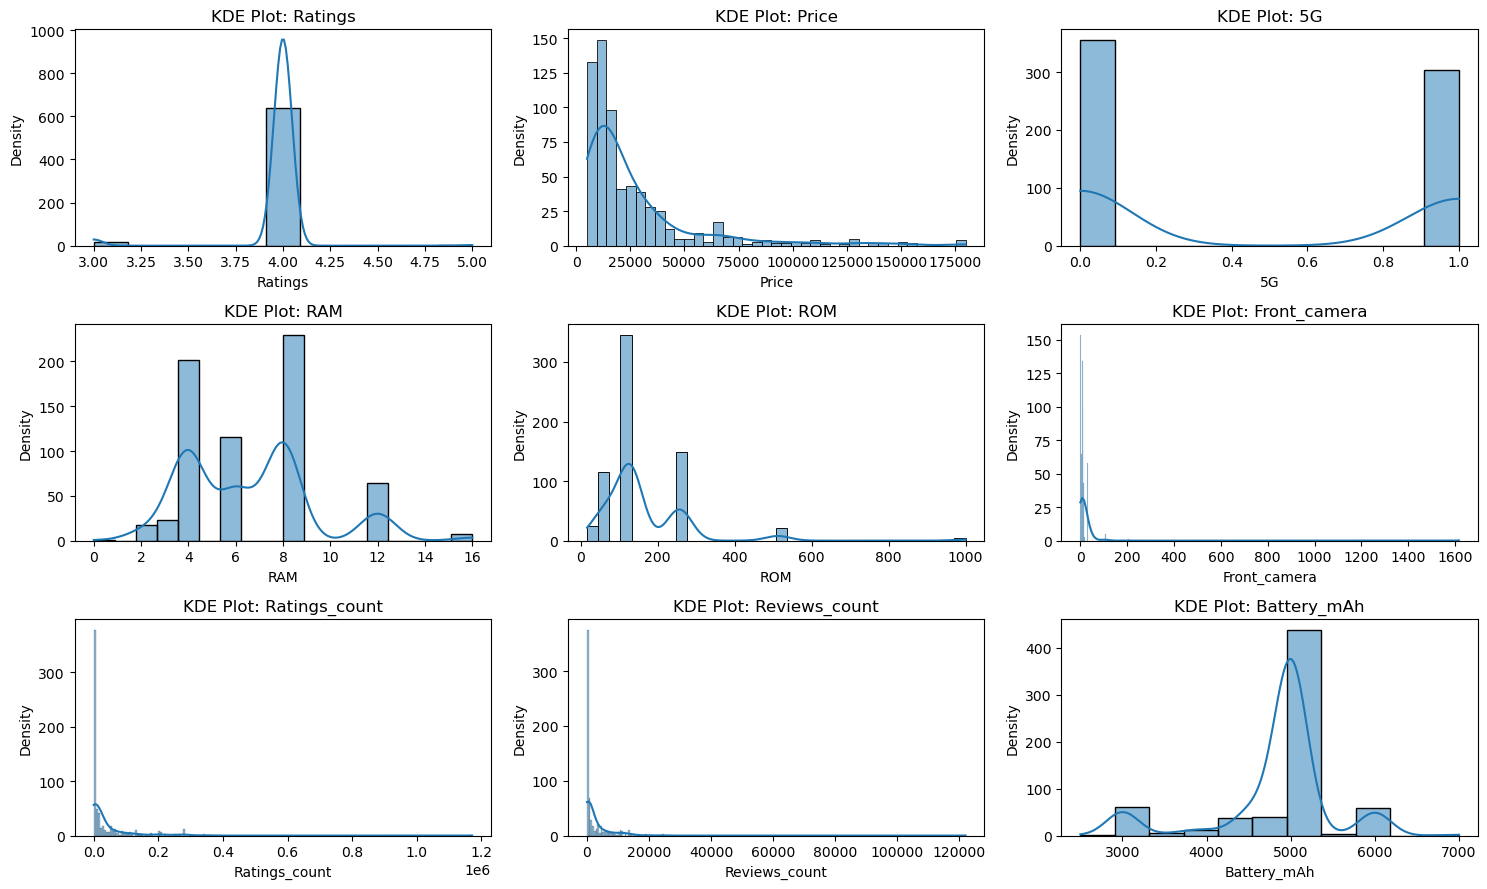

In [53]:
col = ['Ratings', 'Price', '5G', 'RAM', 'ROM', 'Front_camera', 'Ratings_count', 'Reviews_count', 'Battery_mAh']
import seaborn as sns
# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 9))
axes = axes.flatten()

# Loop through the columns and create KDE + histogram plots
for i, col_name in enumerate(col):
    sns.histplot(df[col_name], kde=True, ax=axes[i])
    axes[i].set_xlabel(col_name)
    axes[i].set_ylabel('Density')
    axes[i].set_title(f'KDE Plot: {col_name}')

# Adjust layout
plt.tight_layout()
plt.show()

In [54]:
correlation = df[['Ratings', 'Price', '5G', 'RAM', 'ROM', 'Front_camera','Ratings_count', 'Reviews_count', 'Battery_mAh',
       'Back_camera_sum']].corr()

In [55]:
correlation

,Ratings,Price,5G,RAM,ROM,Front_camera,Ratings_count,Reviews_count,Battery_mAh,Back_camera_sum
Ratings,1.000000,0.032627,0.083186,0.103887,0.072961,0.013968,0.050661,0.034114,0.123171,0.090394
Price,0.032627,1.000000,-0.025806,0.245539,0.600722,0.068934,0.006747,-0.029019,-0.584791,0.299195
5G,0.083186,-0.025806,1.000000,0.434330,0.211371,-0.030551,-0.137378,-0.091775,0.214916,0.376291
RAM,0.103887,0.245539,0.434330,1.000000,0.475338,0.151109,-0.200858,-0.139239,0.171498,0.558973
ROM,0.072961,0.600722,0.211371,0.475338,1.000000,0.060931,-0.089422,-0.093725,-0.212476,0.370706
Front_camera,0.013968,0.068934,-0.030551,0.151109,0.060931,1.000000,-0.019323,-0.007036,-0.010575,0.063610
Ratings_count,0.050661,0.006747,-0.137378,-0.200858,-0.089422,-0.019323,1.000000,0.937312,-0.228256,-0.151780
Reviews_count,0.034114,-0.029019,-0.091775,-0.139239,-0.093725,-0.007036,0.937312,1.000000,-0.139946,-0.105631
Battery_mAh,0.123171,-0.584791,0.214916,0.171498,-0.212476,-0.010575,-0.228256,-0.139946,1.000000,0.126825
Back_camera_sum,0.090394,0.299195,0.376291,0.558973,0.370706,0.063610,-0.151780,-0.105631,0.126825,1.000000


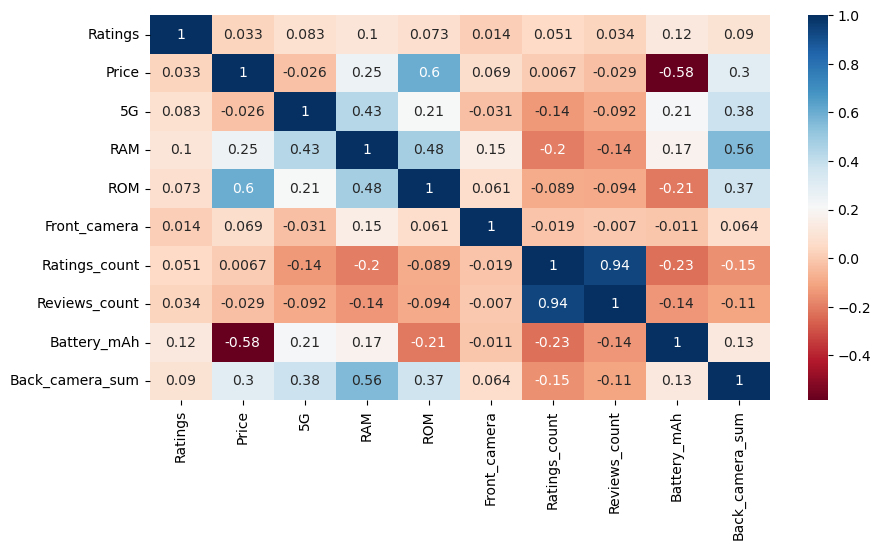

In [56]:
import seaborn as sns
plt.figure(figsize=(10,5))
sns.heatmap(correlation, annot=True, cmap="RdBu")
plt.show()

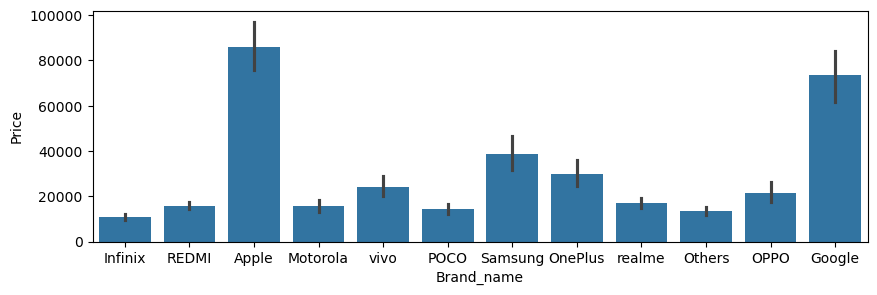

In [57]:
plt.figure(figsize=(10,3))
sns.barplot(x= "Brand_name", y="Price", data=df)
plt.show()

### Findings after Data Analysis:

- Maximum Smartphones have been rated more than 4 out of 5.
- Maximum Smartphones have more than 4Gb of RAM.
- Maximum Smartphones have more than 64Gb of ROM.
- Most Smartphones have Mediatek Processors followed by Snapdragon.
- Most Smartphones have 5000 mAh of battery.
- With increase Ratings the Prices of Smartphones also increases.
- Apple and Google are the most costliest Smartphones.
- Both 4g ang 5g Smartphones almost have same price values.
- The distribution of the Price, Reviews and Ratings_count are higly Right Skewed.
- Price have a high postivie Correlation with ROM.
- Price have a slight positive Correlation with Back_Camera, Front_Camera, RAM.

# Step 4: Model Selection, Training & Evaluation

In [60]:
df.sample(3)

,Ratings,Price,Brand_name,5G,RAM,ROM,Front_camera,Processor_name,Ratings_count,Reviews_count,Battery_mAh,Back_camera_sum
604,4,50999,Apple,0,4,128,12,Bionic,207953,13797,3000,24
808,4,9825,Others,1,4,64,8,Mediatek,645,48,5000,50
977,4,6649,Others,0,2,32,5,Others,910,48,5000,8


In [61]:
ml_df = df.drop(columns = ['Ratings', 'Ratings_count', 'Reviews_count', 'Battery_mAh'])
ml_df.sample(5)

,Price,Brand_name,5G,RAM,ROM,Front_camera,Processor_name,Back_camera_sum
705,16889,Others,1,8,256,0,Others,50
807,11999,Others,0,8,128,0,Others,50
621,11999,vivo,0,6,128,8,Mediatek,52
447,64999,Samsung,1,8,128,12,Snapdragon,72
738,24999,realme,1,8,256,16,Mediatek,102


In [62]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 660 entries, 0 to 983
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Price            660 non-null    int32 
 1   Brand_name       660 non-null    object
 2   5G               660 non-null    int32 
 3   RAM              660 non-null    int32 
 4   ROM              660 non-null    int32 
 5   Front_camera     660 non-null    int32 
 6   Processor_name   660 non-null    object
 7   Back_camera_sum  660 non-null    int64 
dtypes: int32(5), int64(1), object(2)
memory usage: 33.5+ KB


In [63]:
ml_df.to_csv("Dataset_used_for_modeling.csv", index = False)

# Machine learning Algorithms

In [65]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 660 entries, 0 to 983
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Price            660 non-null    int32 
 1   Brand_name       660 non-null    object
 2   5G               660 non-null    int32 
 3   RAM              660 non-null    int32 
 4   ROM              660 non-null    int32 
 5   Front_camera     660 non-null    int32 
 6   Processor_name   660 non-null    object
 7   Back_camera_sum  660 non-null    int64 
dtypes: int32(5), int64(1), object(2)
memory usage: 33.5+ KB


In [66]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [67]:
# metrics to check the performace of the regression model
from sklearn.metrics import mean_squared_error, r2_score
def model_performance(y_test, y_predict):
    print("mean sqaure error:", mean_squared_error(y_test, y_predict))
    print("root mean sqaure error:", np.sqrt(mean_squared_error(y_test, y_predict)))
    print("R2 score:", r2_score(y_test, y_predict))

In [68]:
categorical_columns = ['Brand_name', 'Processor_name']
df_encoded = pd.get_dummies(ml_df, columns=categorical_columns)


In [69]:
df_encoded.sample(5)

,Price,5G,RAM,ROM,Front_camera,Back_camera_sum,Brand_name_Apple,Brand_name_Google,Brand_name_Infinix,Brand_name_Motorola,...,Brand_name_Others,Brand_name_POCO,Brand_name_REDMI,Brand_name_Samsung,Brand_name_realme,Brand_name_vivo,Processor_name_Bionic,Processor_name_Mediatek,Processor_name_Others,Processor_name_Snapdragon
388,6292,0,4,64,0,13,False,False,False,False,...,True,False,False,False,False,False,False,False,True,False
6,21999,1,8,256,50,123,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
625,13749,1,6,128,0,50,False,False,False,False,...,True,False,False,False,False,False,False,False,True,False
435,18999,1,6,128,13,58,False,False,False,False,...,False,True,False,False,False,False,False,False,False,True
144,6499,0,4,64,5,13,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False


In [70]:
# Convert all boolean columns to integers
df_encoded = df_encoded.astype(int)


In [71]:
df_encoded.sample(5)

,Price,5G,RAM,ROM,Front_camera,Back_camera_sum,Brand_name_Apple,Brand_name_Google,Brand_name_Infinix,Brand_name_Motorola,...,Brand_name_Others,Brand_name_POCO,Brand_name_REDMI,Brand_name_Samsung,Brand_name_realme,Brand_name_vivo,Processor_name_Bionic,Processor_name_Mediatek,Processor_name_Others,Processor_name_Snapdragon
299,7299,0,4,128,5,13,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
978,6599,0,2,32,5,8,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
923,95999,0,4,512,12,60,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
880,15999,1,4,128,16,52,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
355,7587,0,4,128,55,16,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [72]:
df_encoded.columns

Index(['Price', '5G', 'RAM', 'ROM', 'Front_camera', 'Back_camera_sum',
       'Brand_name_Apple', 'Brand_name_Google', 'Brand_name_Infinix',
       'Brand_name_Motorola', 'Brand_name_OPPO', 'Brand_name_OnePlus',
       'Brand_name_Others', 'Brand_name_POCO', 'Brand_name_REDMI',
       'Brand_name_Samsung', 'Brand_name_realme', 'Brand_name_vivo',
       'Processor_name_Bionic', 'Processor_name_Mediatek',
       'Processor_name_Others', 'Processor_name_Snapdragon'],
      dtype='object')

In [73]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 660 entries, 0 to 983
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Price                      660 non-null    int32
 1   5G                         660 non-null    int32
 2   RAM                        660 non-null    int32
 3   ROM                        660 non-null    int32
 4   Front_camera               660 non-null    int32
 5   Back_camera_sum            660 non-null    int32
 6   Brand_name_Apple           660 non-null    int32
 7   Brand_name_Google          660 non-null    int32
 8   Brand_name_Infinix         660 non-null    int32
 9   Brand_name_Motorola        660 non-null    int32
 10  Brand_name_OPPO            660 non-null    int32
 11  Brand_name_OnePlus         660 non-null    int32
 12  Brand_name_Others          660 non-null    int32
 13  Brand_name_POCO            660 non-null    int32
 14  Brand_name_REDMI           660 

In [74]:
X = df_encoded.drop('Price', axis=1)
y = df_encoded['Price']


In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [76]:
# Scaling your data
# Importing StandardScaler library
from sklearn.preprocessing import StandardScaler
# Creating object
ss= StandardScaler()

# Fit and Transform
X_train_scaled= ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [77]:
X_train_scaled

array([[ 1.07885793,  0.52408942, -0.2713875 , ...,  1.39632398,
        -0.8385856 , -0.45025935],
       [ 1.07885793,  0.52408942, -0.2713875 , ..., -0.71616617,
        -0.8385856 ,  2.2209422 ],
       [-0.92690611,  0.52408942, -0.2713875 , ...,  1.39632398,
        -0.8385856 , -0.45025935],
       ...,
       [ 1.07885793,  0.52408942,  0.82244914, ..., -0.71616617,
         1.19248411, -0.45025935],
       [-0.92690611, -0.93617028, -0.2713875 , ..., -0.71616617,
        -0.8385856 , -0.45025935],
       [-0.92690611, -0.20604043, -0.2713875 , ...,  1.39632398,
        -0.8385856 , -0.45025935]])

In [78]:
y_train

18     14999
524    45999
883    17999
805     8450
85     18863
       ...  
99      8499
161    27999
403    19900
629    50999
157     6999
Name: Price, Length: 528, dtype: int32

## Machine Learning Model 1 (Linear Regression)


In [80]:
# Importing LinearRegression from sklearn
from sklearn.linear_model import LinearRegression

# Create a Linear Regression model
lr = LinearRegression()

# Fit the model on the training data
lr.fit(X_train_scaled, y_train)

# Predict on the test set
y_linear_pred = lr.predict(X_test_scaled)

In [81]:

# Evaluate model performance
model_performance(y_test, y_linear_pred)

mean sqaure error: 288531536.12692773
root mean sqaure error: 16986.21606264702
R2 score: 0.7503711370989328


#### The performance of Linear Regression is worst, so applying another machine learning algorithm.

## Machine Learning Model 2 (RandomForestRegressor)

In [84]:
# import the regressor
from sklearn.ensemble import RandomForestRegressor

# create a regressor object
RF_TreeR = RandomForestRegressor(n_estimators=50, max_depth=18)

# fit the regressor with X and Y data
RF_TreeR.fit(X_train_scaled, y_train)

# predict the model

y_test_RFtree_pred= RF_TreeR.predict(X_test_scaled)

In [85]:
model_performance(y_test, y_test_RFtree_pred)

mean sqaure error: 41589820.46306378
root mean sqaure error: 6449.017015256184
R2 score: 0.9640177301593577


In [86]:
# Import necessary libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Creating RandomForestRegressor instance
RF_tree = RandomForestRegressor()

# Defining parameters
parameters = {
    'n_estimators': [5, 10, 25, 30, 35],
    'max_depth': [10, 15, 20, 25, 30],
    'min_samples_leaf': [0.5, 1, 2, 3, 4]
}

# Train the model using GridSearchCV
RF_treeG = GridSearchCV(RF_tree, parameters, n_jobs=-1, scoring='neg_mean_squared_error', cv=3, verbose=3)
RF_treeG.fit(X_train_scaled, y_train)

# Predict the output
y_test_grid_RFtree_pred = RF_treeG.predict(X_test_scaled)

# Printing the best parameters obtained by GridSearchCV
print(f"The best values found out to be: {RF_treeG.best_params_}")
print(f"Negative mean square error is: {RF_treeG.best_score_}")


Fitting 3 folds for each of 125 candidates, totalling 375 fits
The best values found out to be: {'max_depth': 30, 'min_samples_leaf': 1, 'n_estimators': 30}
Negative mean square error is: -93911378.65919392


In [87]:
model_performance(y_test, y_test_grid_RFtree_pred)

mean sqaure error: 36886772.54929918
root mean sqaure error: 6073.44815976058
R2 score: 0.9680866666736867


#### The performance of Random Forest Regression is better than Linear Regression but we will applying other machine learning algorithms also.

## Training (XGBRegressor)

In [90]:
# ML Model - 3 Implementation
# import the regressor
from xgboost import XGBRegressor

# create a regressor object
xgbR = XGBRegressor()

# fit the regressor with X and Y data
xgbR.fit(X_train_scaled, y_train)

# predict the model
y_test_xgbR_pred= xgbR.predict(X_test_scaled)

In [91]:
model_performance(y_test, y_test_xgbR_pred)

mean sqaure error: 27825383.762841433
root mean sqaure error: 5274.977133869059
R2 score: 0.975926309471252


In [92]:
# XGBoost with RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# Creating XGBoost instance
xgb= XGBRegressor()

# Defining parameters
parameters={"learning_rate":[0.1, 0.5, 0.2, 0.3, 0.4],"max_depth":[2,4,6,8,10]}

# Train the model
xgb_Rand_R= GridSearchCV(xgb,parameters,scoring='neg_mean_squared_error',n_jobs=-1,cv=3,verbose=3)
xgb_Rand_R.fit(X_train_scaled,y_train)

# Predict the output
y_test_rand_xgbR_pred = xgb_Rand_R.predict(X_test_scaled)

# Printing the best parameters obtained by GridSearchCV
print(f"The best alpha value found out to be: {xgb_Rand_R.best_params_}")
print(f"Negative mean square error is: {xgb_Rand_R.best_score_}")

Fitting 3 folds for each of 25 candidates, totalling 75 fits
The best alpha value found out to be: {'learning_rate': 0.3, 'max_depth': 6}
Negative mean square error is: -79247586.2468558


In [93]:
model_performance(y_test, y_test_rand_xgbR_pred)

mean sqaure error: 27825383.762841433
root mean sqaure error: 5274.977133869059
R2 score: 0.975926309471252


## Final Model.

In [95]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalize the data
    ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42))  # XGBoost regressor
])


In [96]:
pipeline.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('xgb',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [97]:
y_pred = pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R² Score: {r2}')


MAE: 2448.980535333807
MSE: 27825383.762841433
R² Score: 0.975926309471252


### Final Result

**MAE: 2448.980535333807**

**RMSE: 5273.076**

**R² Score: 0.975926309471252**

In [99]:
import pickle

# Save the model
with open('model.pkl', 'wb') as file:
    pickle.dump(pipeline, file)
